In [1]:
#!/usr/bin/env python
# encoding: utf-8
from __future__ import absolute_import, division, print_function, unicode_literals
# Install TensorFlow
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten , Convolution2D, MaxPooling2D , Lambda, Conv2D, Activation,Concatenate
from tensorflow.keras.layers import ActivityRegularization
from tensorflow.keras.optimizers import Adam , SGD , Adagrad
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, CSVLogger, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

from tensorflow.keras import regularizers , initializers
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import NumpyArrayIterator



gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#   # Restrict TensorFlow to only use the first GPU
try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    tf.config.experimental.set_virtual_device_configuration(
    gpus[0],
    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1000)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
except RuntimeError as e:
# Visible devices must be set before GPUs have been initialized
    print(e)



from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
# from xgboost import XGBClassifier
import tensorflow.keras.backend as K
from sklearn import metrics

# !pip3 install keras-tuner --upgrade
# !pip3 install autokeras
import kerastuner as kt
import autokeras as ak

#Plot's Making  Packages
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, MultipleLocator, AutoMinorLocator
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, BoundaryNorm
from matplotlib.collections import LineCollection
from matplotlib import cm
from matplotlib import font_manager


# Import local libraries
import numpy as np
import h5py
import time
import pandas as pd
import importlib
from scipy import interpolate
import os
from tqdm import tqdm 

import logging

importlib.reload(logging)
logging.basicConfig(level = logging.INFO)

os.environ['NUMEXPR_MAX_THREADS'] = '64'
os.environ['NUMEXPR_NUM_THREADS'] = '64'

print("Tensorflow Version is {}".format(tf.__version__))
print("Keras Version is {}".format(tf.keras.__version__))
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
tf.device('/device:XLA_GPU:0')
!nvidia-smi

%config InlineBackend. figure_format = 'retina'

1 Physical GPUs, 1 Logical GPU
Tensorflow Version is 2.4.1
Keras Version is 2.4.0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 508566207667209833
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1048576000
locality {
  bus_id: 2
  numa_node: 1
  links {
  }
}
incarnation: 13714382560914373880
physical_device_desc: "device: 0, name: A100-SXM-80GB, pci bus id: 0000:4c:00.0, compute capability: 8.0"
]
Mon Nov 29 14:26:25 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.73.01    Driver Version: 460.73.01    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|==============================

In [19]:
%%time
HOMEPATH = "/dicos_ui_home/alanchung/Universality_Boosetd_Higgs/"
Data_High_Level_Features_path =  HOMEPATH + "Data_High_Level_Features/"
savepath = HOMEPATH + "Data_ML/"



data_train = {
        "herwig_ang_train" : 0,
        "pythia_def_train" : 0,
        "pythia_vin_train" : 0,
        "pythia_dip_train" : 0,
#             "sherpa_def_train" : 0
        }  

data_test = {
        "herwig_ang_test" : 0,
        "pythia_def_test" : 0,
        "pythia_vin_test" : 0,
        "pythia_dip_test" : 0,
#             "sherpa_def_test" : 0
        }  


DNN_Model_A1 = {
      "herwig_ang" : 0,
      "pythia_def" : 0, 
      "pythia_vin" : 0, 
      "pythia_dip" : 0, 
#       "sherpa_def" : 0,
    }

       
for i, model in enumerate(DNN_Model_A1): 
    logging.info("DNN Model: {}".format(model))

    for j, (traindata, testdata) in enumerate(zip(data_train,data_test)):


        """
        Pt Range Study
        """
    #         for k, (pt_min, pt_max) in  enumerate(zip([300,400,500,600,700,800],[400,500,600,700,800,900])):
        for k, (pt_min, pt_max) in  enumerate(zip([300],[500])):

            train_data_path = HOMEPATH + "Notebook/KFold/" + str(traindata) + ".csv"
            if os.path.exists(train_data_path):
                tmp = pd.read_csv(train_data_path)
            else:
                raise ValueError("Pleas check training data path !!")

            tmp = tmp[(tmp["PTJ_0"] >= pt_min)  & (tmp["PTJ_0"] < pt_max)]
#             tmp = tmp[(tmp["PTJ_0"] >= 300)  & (tmp["PTJ_0"] < 500)]
            tmp = tmp[(tmp["MJ_0"] >= 110)  & (tmp["MJ_0"] < 160)]
            data_train[traindata] = shuffle(tmp)#[:30000]


#             test_data_path = HOMEPATH + "Notebook/KFold/" + str(testdata) + ".csv"
#             if os.path.exists(test_data_path):
#                 tmp = pd.read_csv(test_data_path)
#             else:
#                 raise ValueError("Pleas check test data path !!")

#             tmp = tmp[(tmp["PTJ_0"] >= pt_min)  & (tmp["PTJ_0"] < pt_max)]
#             tmp = tmp[(tmp["MJ_0"] >= 110)  & (tmp["MJ_0"] < 160)]
#             data_test[testdata] = shuffle(tmp)

            logging.info("START===========================================START")
            logging.info("\r") 
            logging.info("All Files are loaded!")
            logging.info("pt min: {} , pt max: {}".format(pt_min, pt_max))
            logging.info("\r")
            logging.info("H jet : QCD jet = 1 : 1")

            train = len(data_train[traindata])
#             test = len(data_test[testdata])
        #     logging.info("{:^8}{:^15}{:^15}{:^15}{:^15}".format("","Herwig Angular","Pythia Default","Pythia Vincia","Pythia Dipole"))
        #     logging.info("{:^8}{:^15}{:^15}{:^15}{:^15}".format("Train #",train[0],train[1],train[2],train[3]))
    #         logging.info("{:^8}{:^15}".format("",str(testdata)))
            logging.info("{:^8}{:^15}".format("Train #",train))
#             logging.info("{:^8}{:^15}".format("Test #",test))






            features = ["MJ_0","t21_0","D21_0","D22_0","C21_0","C22_0"] 


            kf = KFold(n_splits = 50)
            # kf = GroupKFold(n_splits = 100)
#             skf = StratifiedKFold(n_splits = 2, random_state = 7, shuffle = True) 

#             model = "pythia_def"

            logging.info("DNN Model: {}  Test Data: {}".format(model, traindata))
            time.sleep(0.5)
            for model_index, (train_index, val_index) in tqdm(enumerate(kf.split(data_train[traindata]["target"]))):
                ticks_1 = time.time()

    #             logging.info("TRAIN: {} VAL: {}".format(train_index, val_index))
    #                 training_data = data_train[traindata].iloc[train_index]
                validation_data = data_train[traindata].iloc[val_index]
#                 logging.info(len(validation_data[validation_data["target"]==0]))
    #             validation_data = data_train[traindata]
    #                 validation_data = data_test[testdata]

        #         print(len(training_data[training_data["target"]==1])/len(training_data))
        #         print(len(validation_data[validation_data["target"]==0])/len(validation_data))
        #         print(len(training_data)/len(data_train[trainingdata]))
        #         print(len(validation_data)/len(data_train[trainingdata]))
        #         print(model_index)

                Performance_Frame = {
                "AUC" : [0],
                "max_sig" : [0],
                "r05" : [0],
                "time": [0]
                }


                filepath = "./"+str(model)+"_KFold/DNN_"+str(model)+"_Models_"+str(int(pt_min))+str(int(pt_max))+"/" + str(model) + "_DNN_"+str(model_index)+ ".h5"
                if os.path.exists(filepath):
    #                     DNN_Model_A1[model] = load_model(filepath)

                    model_DNN = load_model(filepath)

                    prediction_test =  model_DNN.predict(np.asarray(validation_data[features]))
                    discriminator_test = prediction_test
                    discriminator_test = discriminator_test/(max(discriminator_test))

                    Performance_Frame["AUC"][0] = metrics.roc_auc_score(validation_data["target"], discriminator_test)
                    FalsePositiveFull, TruePositiveFull, _ = metrics.roc_curve(validation_data["target"], discriminator_test)
                    tmp = np.where(FalsePositiveFull != 0)
                    Performance_Frame["max_sig"][0] = max(TruePositiveFull[tmp]/np.sqrt(FalsePositiveFull[tmp])) 
                    tmp = np.where(TruePositiveFull >= 0.5)
                    Performance_Frame["r05"][0]= 1./FalsePositiveFull[tmp[0][0]]

                    Performance_Frame["time"][0] = (time.time() - ticks_1)/60.

                    dataframe = pd.DataFrame(Performance_Frame)



                    csvdata_path = "./"+str(model)+"_KFold/DNN_"+str(model)+"_Performance_Table_to_"+str(traindata)+"_"+str(pt_min)+str(pt_max)+".csv"
                    if os.path.exists(csvdata_path):
                        save_to_csvdata = pd.read_csv(csvdata_path)
                        DATA = pd.concat([save_to_csvdata, dataframe], ignore_index=True, axis=0,join='inner')
                        DATA.to_csv(csvdata_path, index = 0)

                    else:
                        dataframe.to_csv(csvdata_path, index = 0)


                else:
                    raise ValueError("Pleas check model path !!")


            logging.info("There are {} events for each test.".format(len(validation_data)))
            logging.info("{} DNN models apply on {} is finished!!".format(model,traindata))
            logging.info("END===========================================END")
            logging.info("\n")


    logging.info("\n")
    logging.info("\n")


INFO:root:DNN Model: herwig_ang
INFO:root:START===========================================START
INFO:root:
INFO:root:All Files are loaded!
INFO:root:pt min: 300 , pt max: 500
INFO:root:
INFO:root:H jet : QCD jet = 1 : 1
INFO:root:Train #     307456     
INFO:root:DNN Model: herwig_ang  Test Data: herwig_ang_train
50it [00:12,  3.87it/s]
INFO:root:There are 6149 events for each test.
INFO:root:herwig_ang DNN models apply on herwig_ang_train is finished!!
INFO:root:END===========================================END
INFO:root:

INFO:root:START===========================================START
INFO:root:
INFO:root:All Files are loaded!
INFO:root:pt min: 300 , pt max: 500
INFO:root:
INFO:root:H jet : QCD jet = 1 : 1
INFO:root:Train #     307456     
INFO:root:DNN Model: herwig_ang  Test Data: pythia_def_train
50it [00:12,  4.01it/s]
INFO:root:There are 6149 events for each test.
INFO:root:herwig_ang DNN models apply on pythia_def_train is finished!!
INFO:root:END===============================

CPU times: user 3min 23s, sys: 19.1 s, total: 3min 42s
Wall time: 3min 31s


In [20]:
%%time
DNN_Model_A1 = {
              "herwig_ang" : 0,
#               "pythia_def" : 0, 
#               "pythia_vin" : 0, 
#               "pythia_dip" : 0, 
#               "sherpa_def" : 0,
            }

Performance_Frame = {
            "herwig_ang_train" : 0,
            "pythia_def_train" : 0,
            "pythia_vin_train" : 0,
            "pythia_dip_train" : 0,
        }  

        
# index=["Herwig Angular", "Pythia Default", "Pythia Vincia", "Pythia Dipole", "Average", "STD"]

for i, model in enumerate(DNN_Model_A1): 
    logging.info("DNN Model: {} ".format(model))
    

    
    for j, element in enumerate(Performance_Frame): 
        
        Performance = {
                    "AUC" : [0,0,0,0,0,0],
                    "AUC std" : [0,0,0,0,0,0],
                    "max_sig" : [0,0,0,0,0,0],
                    "max_sig std" : [0,0,0,0,0,0],
                    "r05" : [0,0,0,0,0,0],
                    "r05 std" : [0,0,0,0,0,0],
                    "time": [0,0,0,0,0,0],
                    "time std" : [0,0,0,0,0,0],
                    }

    
#         for k, (pt_min, pt_max) in  enumerate(zip([300,400,500,600,700,800],[400,500,600,700,800,900])):
        for k, (pt_min, pt_max) in  enumerate(zip([300],[500])):
            Performance_Table = pd.read_csv("./"+str(model)+"_KFold/DNN_"+str(model)+"_Performance_Table_to_"+str(element)+"_"+str(pt_min)+str(pt_max)+".csv")
#             Performance_Table = pd.read_csv("./"+str(model)+"_KFold/DNN_"+str(model)+"_Performance_Table_to_"+str(element)+"_"+str(pt_min)+str(pt_max)+".csv")
            
            logging.info(len(Performance_Table))

            Performance_Table.drop(Performance_Table[Performance_Table["AUC"] <= 0.7].index, inplace=True)
            Performance_Table.drop(Performance_Table[Performance_Table["AUC"] == 1].index, inplace=True)
            Performance["AUC"][k] = Performance_Table["AUC"].mean()
            Performance["AUC std"][k] = Performance_Table["AUC"].std()
            Performance["max_sig"][k] = Performance_Table["max_sig"].mean()
            Performance["max_sig std"][k] = Performance_Table["max_sig"].std()
            Performance["r05"][k] = Performance_Table["r05"].mean()
            Performance["r05 std"][k] = Performance_Table["r05"].std()
            Performance["time"][k] = Performance_Table["time"].mean()
            Performance["time std"][k] = Performance_Table["time"].std()



#         Performance_Frame[element] = pd.DataFrame(Performance,
#                      index=["pt300400","pt400500","pt500600","pt600700","pt700800","pt800900"]
#                     )
        
        Performance_Frame[element] = pd.DataFrame(Performance,
                     index=["pt3001100","null","null","null","null","null"]
                    )

INFO:root:DNN Model: herwig_ang 
INFO:root:50
INFO:root:50
INFO:root:50
INFO:root:50


CPU times: user 23.7 ms, sys: 4.22 ms, total: 27.9 ms
Wall time: 28.1 ms


In [21]:
Performance_Frame["herwig_ang_train"]

,AUC,AUC std,max_sig,max_sig std,r05,r05 std,time,time std
pt3001100,0.810252,0.004193,1.773932,0.256101,10.240659,0.579858,0.003906,0.000834
null,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
null,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
null,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
null,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
null,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [22]:
Performance_Frame["pythia_def_train"]

,AUC,AUC std,max_sig,max_sig std,r05,r05 std,time,time std
pt3001100,0.839317,0.006604,2.7568,0.758714,14.990707,1.467769,0.004066,0.002773
null,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000
null,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000
null,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000
null,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000
null,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000


In [23]:
Performance_Frame["pythia_vin_train"]

,AUC,AUC std,max_sig,max_sig std,r05,r05 std,time,time std
pt3001100,0.859353,0.004957,4.796081,1.464089,22.830398,2.327796,0.004056,0.001582
null,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
null,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
null,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
null,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
null,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [24]:
Performance_Frame["pythia_dip_train"]

,AUC,AUC std,max_sig,max_sig std,r05,r05 std,time,time std
pt3001100,0.853668,0.005182,3.543532,0.77873,20.355757,1.927979,0.003867,0.000842
null,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
null,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
null,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
null,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
null,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000


In [25]:
metric = "AUC"

print(np.mean([Performance_Frame["herwig_ang_train"][metric],Performance_Frame["pythia_def_train"][metric],Performance_Frame["pythia_vin_train"][metric],Performance_Frame["pythia_dip_train"][metric]], axis=0))
print(np.std([Performance_Frame["herwig_ang_train"][metric],Performance_Frame["pythia_def_train"][metric],Performance_Frame["pythia_vin_train"][metric],Performance_Frame["pythia_dip_train"][metric]], axis=0))



[0.84064741 0.         0.         0.         0.         0.        ]
[0.01900715 0.         0.         0.         0.         0.        ]


In [37]:
%%time
DNN_Model_A1 = {
              "herwig_ang" : 0,
              "pythia_def" : 0, 
              "pythia_vin" : 0, 
              "pythia_dip" : 0, 
#               "sherpa_def" : 0,
            }

Performance_Frame = {
            "herwig_ang_train" : 0,
            "pythia_def_train" : 0,
            "pythia_vin_train" : 0,
            "pythia_dip_train" : 0,
        }  

        
# index=["Herwig Angular", "Pythia Default", "Pythia Vincia", "Pythia Dipole", "Average", "STD"]

Performance_Summary = {
            "row1" : [0,0,0,0],
            "row2" : [0,0,0,0],
            "row3" : [0,0,0,0],
            "row4" : [0,0,0,0],
            "row5" : [0,0,0,0],
            }


    
for i, element in enumerate(Performance_Frame): 
    logging.info("test on {}".format(element))
    
    for j, model in enumerate(DNN_Model_A1): 
        logging.info("DNN Model: {} ".format(model))
        
        Performance = {
                    "AUC" : [0,0,0,0,0,0],
                    "AUC std" : [0,0,0,0,0,0],
                    "max_sig" : [0,0,0,0,0,0],
                    "max_sig std" : [0,0,0,0,0,0],
                    "r05" : [0,0,0,0,0,0],
                    "r05 std" : [0,0,0,0,0,0],
                    "time": [0,0,0,0,0,0],
                    "time std" : [0,0,0,0,0,0],
                    }

    
#         for k, (pt_min, pt_max) in  enumerate(zip([300,400,500,600,700,800],[400,500,600,700,800,900])):
        for k, (pt_min, pt_max) in  enumerate(zip([300],[500])):
            Performance_Table = pd.read_csv("./"+str(model)+"_KFold/DNN_"+str(model)+"_Performance_Table_to_"+str(element)+"_"+str(pt_min)+str(pt_max)+".csv")
#             Performance_Table = pd.read_csv("./"+str(model)+"_KFold/DNN_"+str(model)+"_Performance_Table_to_"+str(element)+"_"+str(pt_min)+str(pt_max)+".csv")
            
            logging.info(len(Performance_Table))

            Performance_Table.drop(Performance_Table[Performance_Table["AUC"] <= 0.7].index, inplace=True)
            Performance_Table.drop(Performance_Table[Performance_Table["AUC"] == 1].index, inplace=True)
            Performance["AUC"][k] = Performance_Table["AUC"].mean()
            Performance["AUC std"][k] = Performance_Table["AUC"].std()
            Performance["max_sig"][k] = Performance_Table["max_sig"].mean()
            Performance["max_sig std"][k] = Performance_Table["max_sig"].std()
            Performance["r05"][k] = Performance_Table["r05"].mean()
            Performance["r05 std"][k] = Performance_Table["r05"].std()
            Performance["time"][k] = Performance_Table["time"].mean()
            Performance["time std"][k] = Performance_Table["time"].std()



#         Performance_Frame[element] = pd.DataFrame(Performance,
#                      index=["pt300400","pt400500","pt500600","pt600700","pt700800","pt800900"]
#                     )
        
        DNN_Model_A1[model] = pd.DataFrame(Performance,
                     index=["pt3001100","null","null","null","null","null"]
                    )
        
        
    metric = "max_sig"
    for l, (row, model) in enumerate(zip(Performance_Summary,DNN_Model_A1)): 
            Performance_Summary[row][i] = "${:.2f}\pm{:.2f}$".format(DNN_Model_A1[model][metric][0],DNN_Model_A1[model][metric + " std"][0])
            
    ave = np.mean([DNN_Model_A1["herwig_ang"][metric],DNN_Model_A1["pythia_def"][metric],DNN_Model_A1["pythia_vin"][metric],DNN_Model_A1["pythia_dip"][metric]], axis=0)
    std = np.std([DNN_Model_A1["herwig_ang"][metric],DNN_Model_A1["pythia_def"][metric],DNN_Model_A1["pythia_vin"][metric],DNN_Model_A1["pythia_dip"][metric]], axis=0)
    
    Performance_Summary["row5"][i] = "${:.2f}\pm{:.2f}$".format(ave[0],std[0])

    

INFO:root:test on herwig_ang_train
INFO:root:DNN Model: herwig_ang 
INFO:root:50
INFO:root:DNN Model: pythia_def 
INFO:root:50
INFO:root:DNN Model: pythia_vin 
INFO:root:50
INFO:root:DNN Model: pythia_dip 
INFO:root:50
INFO:root:test on pythia_def_train
INFO:root:DNN Model: herwig_ang 
INFO:root:50
INFO:root:DNN Model: pythia_def 
INFO:root:50
INFO:root:DNN Model: pythia_vin 
INFO:root:50
INFO:root:DNN Model: pythia_dip 
INFO:root:50
INFO:root:test on pythia_vin_train
INFO:root:DNN Model: herwig_ang 
INFO:root:50
INFO:root:DNN Model: pythia_def 
INFO:root:50
INFO:root:DNN Model: pythia_vin 
INFO:root:50
INFO:root:DNN Model: pythia_dip 
INFO:root:50
INFO:root:test on pythia_dip_train
INFO:root:DNN Model: herwig_ang 
INFO:root:50
INFO:root:DNN Model: pythia_def 
INFO:root:50
INFO:root:DNN Model: pythia_vin 
INFO:root:50
INFO:root:DNN Model: pythia_dip 
INFO:root:50


CPU times: user 108 ms, sys: 8.33 ms, total: 117 ms
Wall time: 108 ms


In [38]:
# Format for latex
NAME = ["Herwig Angular", "Pythia Default", "Pythia Vincia", "Pythia Dipole", "Average $\pm$ Std."]
for (element, name) in zip(Performance_Summary, NAME):
    print("\\textbf{"+str(name)+"}","& {} & {} & {} & {}".format(Performance_Summary[element][0],Performance_Summary[element][1],Performance_Summary[element][2],Performance_Summary[element][3]))
    

\textbf{Herwig Angular} & $1.77\pm0.26$ & $2.76\pm0.76$ & $4.80\pm1.46$ & $3.54\pm0.78$
\textbf{Pythia Default} & $1.77\pm0.31$ & $3.15\pm0.84$ & $4.86\pm1.46$ & $4.44\pm1.25$
\textbf{Pythia Vincia} & $1.84\pm0.41$ & $3.03\pm0.70$ & $5.48\pm1.66$ & $4.38\pm1.30$
\textbf{Pythia Dipole} & $1.75\pm0.24$ & $2.94\pm0.70$ & $5.32\pm1.24$ & $4.22\pm0.79$
\textbf{Average $\pm$ Std.} & $1.78\pm0.03$ & $2.97\pm0.14$ & $5.11\pm0.29$ & $4.15\pm0.36$


In [34]:
# metric = "AUC"

# print(np.mean([DNN_Model_A1["herwig_ang"][metric],DNN_Model_A1["pythia_def"][metric],DNN_Model_A1["pythia_vin"][metric],DNN_Model_A1["pythia_dip"][metric]], axis=0))
# print(np.std([DNN_Model_A1["herwig_ang"][metric],DNN_Model_A1["pythia_def"][metric],DNN_Model_A1["pythia_vin"][metric],DNN_Model_A1["pythia_dip"][metric]], axis=0))



## ROC Curves

INFO:root:DNN Model: herwig_ang
INFO:root:START===========================================START
INFO:root:
INFO:root:All Files are loaded!
INFO:root:pt min: 300 , pt max: 500
INFO:root:
INFO:root:H jet : QCD jet = 1 : 1
INFO:root:pythia_dip_train, # of H jet: 153728
INFO:root:pythia_dip_train, # of QCD jet: 153728
INFO:root:Train #     307456     
INFO:root:DNN Model: herwig_ang  Test Data: pythia_dip_train
0it [00:00, ?it/s]INFO:root:

INFO:root:# of H jet: 15465
INFO:root:# of QCD jet: 15281
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:136: RuntimeWarning: divide by zero encountered in true_divide
3it [00:00,  3.91it/s]
INFO:root:There are 30746 events for each test.
INFO:root:herwig_ang DNN models apply on pythia_dip_train is finished!!
INFO:root:END===========================================END
INFO:root:

INFO:root:DNN Model: pythia_def
INFO:root:START===========================================START
INFO:root:
INFO:root:All Files are loaded!
INFO:root:pt min: 300 ,

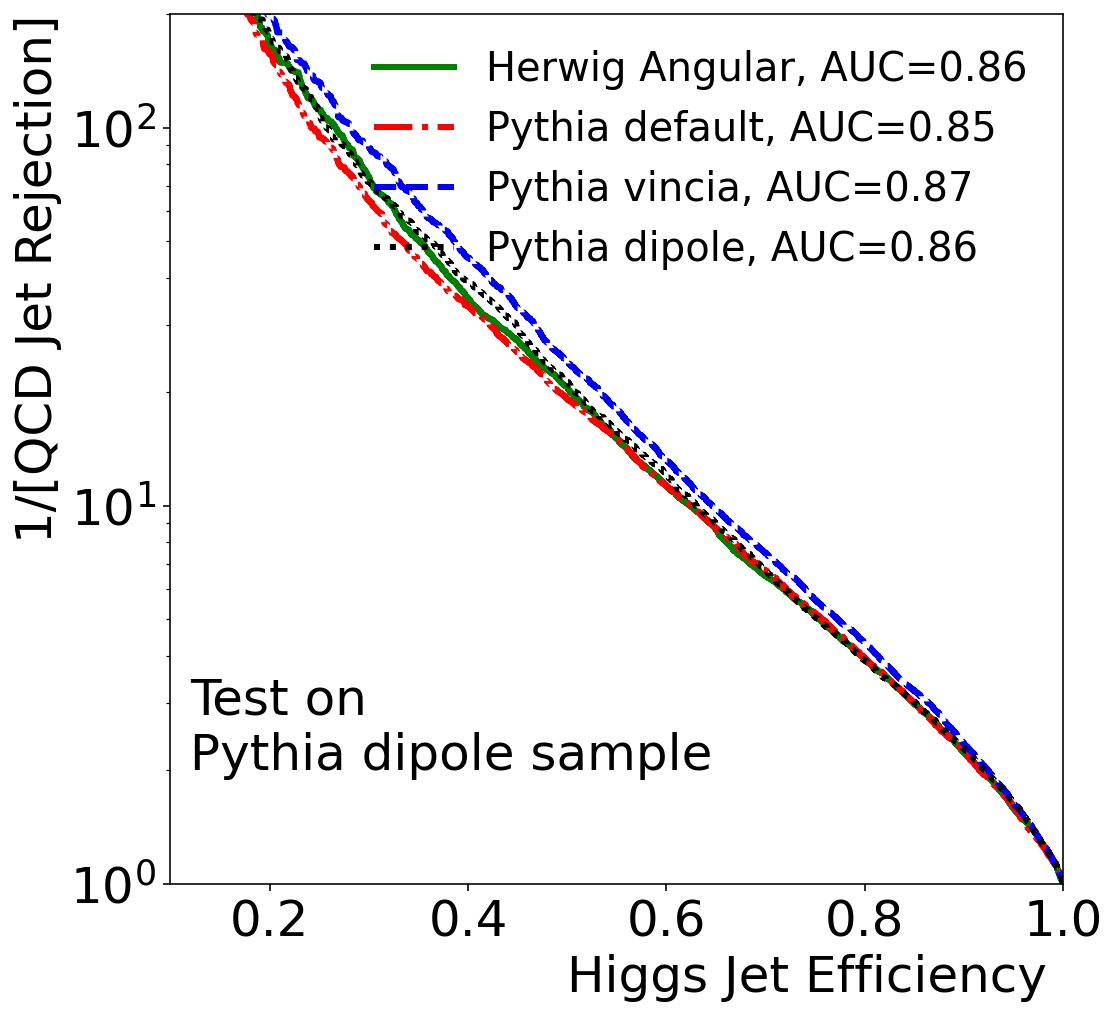

CPU times: user 7.84 s, sys: 599 ms, total: 8.44 s
Wall time: 9.86 s


In [18]:
%%time

fix_model_or_fix_data = 1 # 0:fix model, 1:fix data




HOMEPATH = "/dicos_ui_home/alanchung/Universality_Boosetd_Higgs/"
Data_High_Level_Features_path =  HOMEPATH + "Data_High_Level_Features/"
savepath = HOMEPATH + "Data_ML/"


title = ["Herwig Angular", "Pythia default", "Pythia vincia", "Pythia dipole"]

colors = ["green","red","blue","black"]
linestyle = ["-","-.","--",":"]


data_train = {
#         "herwig_ang_train" : {"index":0, "data":0},
#         "pythia_def_train" : {"index":1, "data":0},
#         "pythia_vin_train" : {"index":2, "data":0},
        "pythia_dip_train" : {"index":3, "data":0},
        }  

DNN_Model_A1 = {
      "herwig_ang" : 0,
      "pythia_def" : 1, 
      "pythia_vin" : 2, 
      "pythia_dip" : 3, 
    }


fig, ax = plt.subplots(1,1, figsize=(8,8)) 

for i, model in enumerate(DNN_Model_A1): 
    logging.info("DNN Model: {}".format(model))

    
    for j, traindata in enumerate(data_train):


        """
        Pt Range Study
        """
        for k, (pt_min, pt_max) in  enumerate(zip([300],[500])):

            train_data_path = HOMEPATH + "Notebook/KFold/" + str(traindata) + ".csv"
            if os.path.exists(train_data_path):
                tmp = pd.read_csv(train_data_path)
            else:
                raise ValueError("Pleas check training data path !!")

            tmp = tmp[(tmp["PTJ_0"] >= pt_min)  & (tmp["PTJ_0"] < pt_max)]
#             tmp = tmp[(tmp["PTJ_0"] >= 300)  & (tmp["PTJ_0"] < 500)]
            tmp = tmp[(tmp["MJ_0"] >= 110)  & (tmp["MJ_0"] < 160)]
            data_train[traindata]["data"] = shuffle(tmp)#[:30000]


            logging.info("START===========================================START")
            logging.info("\r") 
            logging.info("All Files are loaded!")
            logging.info("pt min: {} , pt max: {}".format(pt_min, pt_max))
            logging.info("\r")
            logging.info("H jet : QCD jet = 1 : 1")
            logging.info("{}, # of H jet: {}".format(traindata, len(data_train[traindata]["data"][ data_train[traindata]["data"]["PRO"] == "H"])))
            logging.info("{}, # of QCD jet: {}".format(traindata, len(data_train[traindata]["data"][ data_train[traindata]["data"]["PRO"] == "QCD"])))
        
            
            train = len(data_train[traindata]["data"])
            logging.info("{:^8}{:^15}".format("Train #",train))
            

            features = ["MJ_0","t21_0","D21_0","D22_0","C21_0","C22_0"] 


            kf = KFold(n_splits = 10)
            
#             fig, ax = plt.subplots(1,1, figsize=(9,9))
            

            logging.info("DNN Model: {}  Test Data: {}".format(model, traindata))
            time.sleep(0.5)
            for model_index, (train_index, val_index) in tqdm(enumerate(kf.split(data_train[traindata]["data"]["target"]))):
                
                if model_index == 0 or model_index == 1:
                    continue
                
                if model_index == 3:
                    break
                
                ticks_1 = time.time()
                validation_data = data_train[traindata]["data"].iloc[val_index]
                
                logging.info("\n")
                logging.info("# of H jet: {}".format(len(validation_data[ validation_data["PRO"] == "H"])))
                logging.info("# of QCD jet: {}".format(len(validation_data[ validation_data["PRO"] == "QCD"])))
        
                Performance_Frame = {
                "AUC" : [0],
                "max_sig" : [0],
                "r05" : [0],
                "time": [0]
                }


                filepath = "./"+str(model)+"_KFold/DNN_"+str(model)+"_Models_"+str(int(pt_min))+str(int(pt_max))+"/" + str(model) + "_DNN_"+str(model_index)+ ".h5"
                if os.path.exists(filepath):
                    model_DNN = load_model(filepath)

                    prediction_test =  model_DNN.predict(np.asarray(validation_data[features]))
                    discriminator_test = prediction_test
                    discriminator_test = discriminator_test/(max(discriminator_test))

                    Performance_Frame["AUC"][0] = metrics.roc_auc_score(validation_data["target"], discriminator_test)
                    FalsePositiveFull, TruePositiveFull, _ = metrics.roc_curve(validation_data["target"], discriminator_test)
#                     logging.info("length of FalsePositiveFull and TruePositiveFull: {}, {}".format(len(FalsePositiveFull),len(TruePositiveFull)))
                    tmp = np.where(FalsePositiveFull != 0)
                    Performance_Frame["max_sig"][0] = max(TruePositiveFull[tmp]/np.sqrt(FalsePositiveFull[tmp])) 
                    tmp = np.where(TruePositiveFull >= 0.5)
                    Performance_Frame["r05"][0]= 1./FalsePositiveFull[tmp[0][0]]

                    Performance_Frame["time"][0] = (time.time() - ticks_1)/60.

                    dataframe = pd.DataFrame(Performance_Frame)


                    if fix_model_or_fix_data == 0:
                        plot_index = j
                    elif fix_model_or_fix_data == 1:
                        plot_index = i
                    else:
                        raise ValueError("Pleas check model fixed or data fixed !!")
                        
                    if Performance_Frame["AUC"][0] >= 0.7:
                        plt.plot(
#                                   TruePositiveFull,1-FalsePositiveFull,
                                 TruePositiveFull, 1./FalsePositiveFull,
                                 linewidth = 3,
                                 ls=linestyle[plot_index], 
                                 color=colors[plot_index], 
                                 label="%s, AUC=%.2f" % (title[plot_index],Performance_Frame["AUC"][0])
                                )

                    else:
                        pass
                        
                            
                else:
                    raise ValueError("Pleas check model path !!")

#             plt.xlim((0.1,1))
#             plt.ylim((1, 2E+2))
#             plt.yscale("log")
#             plt.show()
            
            logging.info("There are {} events for each test.".format(len(validation_data)))
            logging.info("{} DNN models apply on {} is finished!!".format(model,traindata))
            logging.info("END===========================================END")
            logging.info("\n")
            
            
            
            
    
    if fix_model_or_fix_data == 0:
        plt.text(0.2,2,"%s model \nTest on different data" % title[DNN_Model_A1[model]], fontsize=20) #Change data_train
        ax.tick_params(axis='x', labelsize=25) #Change data_train
        ax.tick_params(axis='y', labelsize=25) #Change data_train
        plt.xlim((0.1,1)) #Change data_train
    #     plt.xlim((0.1,0.6)) #Change data_train
        plt.ylim((1, 2E+2)) #Change data_train
        plt.yscale("log") #Change data_train
        plt.xlabel('Higgs Jet Efficiency ', fontsize=25,horizontalalignment='right',x=1) #Change data_train
        plt.ylabel('1/[QCD Jet Rejection]', fontsize=25,horizontalalignment='right',y=1) #Change data_train
        plt.legend(ncol=1,fontsize=15, edgecolor = "w",fancybox=False, framealpha=0) #bbox_to_anchor=(0.7, 0.1) #Change data_train
#         plt.savefig("/dicos_ui_home/alanchung/Universality_Boosetd_Higgs/Notebook/Plots/"+str(model)+"_model_change_data_NN.pdf", transparent=True, bbox_inches='tight')
        plt.show() #Change data_train



        logging.info("\n")
        logging.info("\n")
    else:
        pass
    
    
if fix_model_or_fix_data == 1:
#     plt.text(0.2,2,"Different models \nTest on %s data" % title[data_train[traindata]["index"]], fontsize=20)
    plt.text(0.12,2,"Test on \n%s sample" % title[data_train[traindata]["index"]], fontsize=25)
    ax.tick_params(axis='x', labelsize=25) #Change DNN_Model_A1
    ax.tick_params(axis='y', labelsize=25) #Change DNN_Model_A1
    plt.xlim((0.1,1)) #Change DNN_Model_A1
    plt.ylim((1, 2E+2)) #Change DNN_Model_A1
    plt.yscale("log") #Change DNN_Model_A1
    plt.xlabel('Higgs Jet Efficiency ', fontsize=25,horizontalalignment='right',x=1) #Change DNN_Model_A1
    plt.ylabel('1/[QCD Jet Rejection]', fontsize=25,horizontalalignment='right',y=1) #Change DNN_Model_A1
    plt.legend(loc="best",ncol=1,fontsize=20, edgecolor = "w",fancybox=False, framealpha=0) #bbox_to_anchor=(0.7, 0.1) #Change DNN_Model_A1
#     plt.savefig("/dicos_ui_home/alanchung/Universality_Boosetd_Higgs/Notebook/Plots/change_model_"+str(traindata)[:10]+"_data_NN.pdf", transparent=True, bbox_inches='tight')
    plt.show() #Change DNN_Model_A1
    
else:
        pass


INFO:root:DNN Model: herwig_ang
INFO:root:START===========================================START
INFO:root:
INFO:root:All Files are loaded!
INFO:root:pt min: 300 , pt max: 500
INFO:root:
INFO:root:H jet : QCD jet = 1 : 1
INFO:root:herwig_ang_train, # of H jet: 153728
INFO:root:herwig_ang_train, # of QCD jet: 153728
INFO:root:Train #     307456     
INFO:root:DNN Model: herwig_ang  Test Data: herwig_ang_train
50it [00:12,  3.97it/s]
INFO:root:END===========================================END
INFO:root:

INFO:root:DNN Model: pythia_def
INFO:root:START===========================================START
INFO:root:
INFO:root:All Files are loaded!
INFO:root:pt min: 300 , pt max: 500
INFO:root:
INFO:root:H jet : QCD jet = 1 : 1
INFO:root:herwig_ang_train, # of H jet: 153728
INFO:root:herwig_ang_train, # of QCD jet: 153728
INFO:root:Train #     307456     
INFO:root:DNN Model: pythia_def  Test Data: herwig_ang_train
50it [00:13,  3.71it/s]
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.

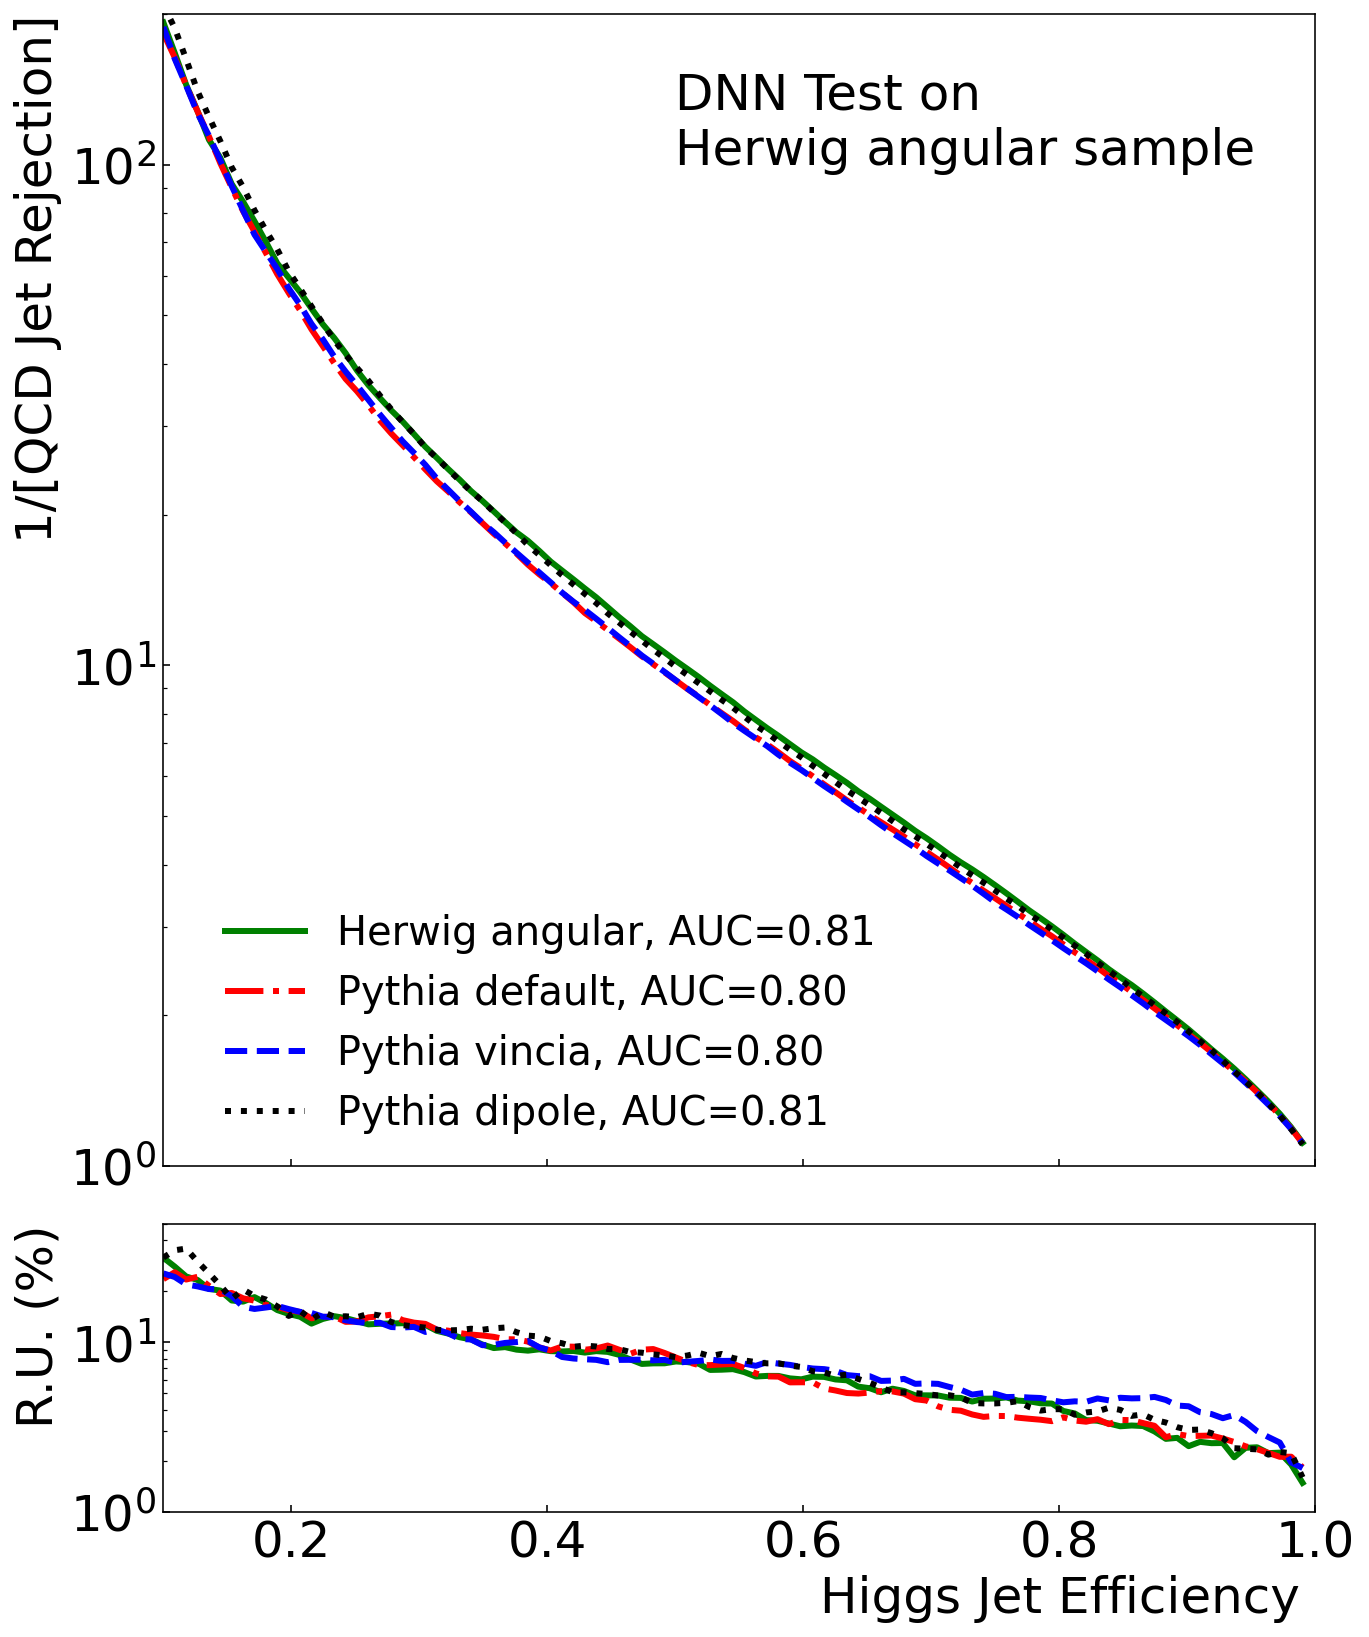

CPU times: user 57.8 s, sys: 5.85 s, total: 1min 3s
Wall time: 1min


In [5]:
%%time

fix_model_or_fix_data = 1 # 0:fix model, 1:fix data




HOMEPATH = "/dicos_ui_home/alanchung/Universality_Boosetd_Higgs/"
Data_High_Level_Features_path =  HOMEPATH + "Data_High_Level_Features/"
savepath = HOMEPATH + "Data_ML/"


title = ["Herwig angular", "Pythia default", "Pythia vincia", "Pythia dipole"]

colors = ["green","red","blue","black"]
linestyle = ["-","-.","--",":"]


data_train = {
        "herwig_ang_train" : {"index":0, "data":0},
#         "pythia_def_train" : {"index":1, "data":0},
#         "pythia_vin_train" : {"index":2, "data":0},
#         "pythia_dip_train" : {"index":3, "data":0},
        }  

DNN_Model_A1 = {
      "herwig_ang" : 0,
      "pythia_def" : 1, 
      "pythia_vin" : 2, 
      "pythia_dip" : 3, 
    }


# fig, ax = plt.subplots(1,1, figsize=(8,8)) 
fig = plt.figure(figsize=(8,8))

for i, model in enumerate(DNN_Model_A1): 
    logging.info("DNN Model: {}".format(model))

    
    for j, traindata in enumerate(data_train):


        """
        Pt Range Study
        """
        for k, (pt_min, pt_max) in  enumerate(zip([300],[500])):

            train_data_path = HOMEPATH + "Notebook/KFold/" + str(traindata) + ".csv"
            if os.path.exists(train_data_path):
                tmp = pd.read_csv(train_data_path)
            else:
                raise ValueError("Pleas check training data path !!")

            tmp = tmp[(tmp["PTJ_0"] >= pt_min)  & (tmp["PTJ_0"] < pt_max)]
#             tmp = tmp[(tmp["PTJ_0"] >= 300)  & (tmp["PTJ_0"] < 500)]
            tmp = tmp[(tmp["MJ_0"] >= 110)  & (tmp["MJ_0"] < 160)]
            data_train[traindata]["data"] = shuffle(tmp)#[:30000]


            logging.info("START===========================================START")
            logging.info("\r") 
            logging.info("All Files are loaded!")
            logging.info("pt min: {} , pt max: {}".format(pt_min, pt_max))
            logging.info("\r")
            logging.info("H jet : QCD jet = 1 : 1")
            logging.info("{}, # of H jet: {}".format(traindata, len(data_train[traindata]["data"][ data_train[traindata]["data"]["PRO"] == "H"])))
            logging.info("{}, # of QCD jet: {}".format(traindata, len(data_train[traindata]["data"][ data_train[traindata]["data"]["PRO"] == "QCD"])))
        
            
            train = len(data_train[traindata]["data"])
            logging.info("{:^8}{:^15}".format("Train #",train))
            

            features = ["MJ_0","t21_0","D21_0","D22_0","C21_0","C22_0"] 


            kf = KFold(n_splits = 50)
            
            Performance_Frame = {
                "AUC" : np.zeros(50),
                "max_sig" : [0],
                "r05" : [0],
                "time": [0]
                }
            FalsePositiveFull_inverse_array = []

            logging.info("DNN Model: {}  Test Data: {}".format(model, traindata))
            time.sleep(0.5)
            
            
            for model_index, (train_index, val_index) in tqdm(enumerate(kf.split(data_train[traindata]["data"]["target"]))):
                
                
                ticks_1 = time.time()
                validation_data = data_train[traindata]["data"].iloc[val_index]


                filepath = "./"+str(model)+"_KFold/DNN_"+str(model)+"_Models_"+str(int(pt_min))+str(int(pt_max))+"/" + str(model) + "_DNN_"+str(model_index)+ ".h5"
                if os.path.exists(filepath):
                    model_DNN = load_model(filepath)

                    prediction_test =  model_DNN.predict(np.asarray(validation_data[features]))
                    discriminator_test = prediction_test
                    discriminator_test = discriminator_test/(max(discriminator_test))

                    Performance_Frame["AUC"][model_index] = metrics.roc_auc_score(validation_data["target"], discriminator_test)
                    if Performance_Frame["AUC"][model_index] < 0.7:
                        continue
                        
                    FalsePositiveFull, TruePositiveFull, _ = metrics.roc_curve(validation_data["target"], discriminator_test)
#                     logging.info("length of FalsePositiveFull and TruePositiveFull: {}, {}".format(len(FalsePositiveFull),len(TruePositiveFull)))
#                     tmp = np.where(FalsePositiveFull != 0)
#                     Performance_Frame["max_sig"][0] = max(TruePositiveFull[tmp]/np.sqrt(FalsePositiveFull[tmp])) 
#                     tmp = np.where(TruePositiveFull >= 0.5)
#                     Performance_Frame["r05"][0]= 1./FalsePositiveFull[tmp[0][0]]

#                     Performance_Frame["time"][0] = (time.time() - ticks_1)/60.

#                     dataframe = pd.DataFrame(Performance_Frame)
                    

#                     """
#                     Remove Duplicated Index: Method 1
#                     """
#                     TruePositiveFull_ = [(element+TruePositiveFull[i+1])/2 for i, element in enumerate(TruePositiveFull) if i+1 < len(TruePositiveFull)]
#                     FalsePositiveFull_ = [(element+FalsePositiveFull[i+1])/2 for i, element in enumerate(FalsePositiveFull) if i+1 < len(FalsePositiveFull)]
#                     TruePositiveFull_ = [(element+TruePositiveFull_[i+1])/2 for i, element in enumerate(TruePositiveFull_) if i+1 < len(TruePositiveFull_)]
#                     FalsePositiveFull_ = [(element+FalsePositiveFull_[i+1])/2 for i, element in enumerate(FalsePositiveFull_) if i+1 < len(FalsePositiveFull_)]
#                     TruePositiveFull_ = [(element+TruePositiveFull_[i+1])/2 for i, element in enumerate(TruePositiveFull_) if i+1 < len(TruePositiveFull_)]
#                     FalsePositiveFull_ = [(element+FalsePositiveFull_[i+1])/2 for i, element in enumerate(FalsePositiveFull_) if i+1 < len(FalsePositiveFull_)]
                
                    """
                    Remove Duplicated Index: Method 2
                    """
                    without_duplicat_index = [i for i, element in enumerate(TruePositiveFull) if i+1 < len(TruePositiveFull) if element!= TruePositiveFull[i+1] ]
                    TruePositiveFull_ = TruePositiveFull[without_duplicat_index]
                    FalsePositiveFull_ = FalsePositiveFull[without_duplicat_index]


                    curve_fit = interpolate.interp1d(TruePositiveFull_, FalsePositiveFull_,kind='previous')
                    plot_range = np.linspace(0.1,0.99,101)
                    FalsePositiveFull_inverse_array.append(1./curve_fit(plot_range))
                
                else:
                    raise ValueError("Pleas check model path !!")

            FalsePositiveFull_inverse_array = np.array(FalsePositiveFull_inverse_array)
            FalsePositiveFull_inverse_average = np.average(FalsePositiveFull_inverse_array, axis=0)
            FalsePositiveFull_inverse_std = np.std(FalsePositiveFull_inverse_array, axis=0)
    
    
            if fix_model_or_fix_data == 0:
                plot_index = j
            elif fix_model_or_fix_data == 1:
                plot_index = i
            else:
                raise ValueError("Pleas check model fixed or data fixed !!")
        
            
            frame1=fig.add_axes((0,0.3,1,1))
            frame1.plot(
                     plot_range, FalsePositiveFull_inverse_average,
                     linewidth = 3,
                     ls=linestyle[plot_index], 
                     color=colors[plot_index], 
#                          label="%s, AUC=%.2f $\pm$ %.3f" % (title[plot_index],np.average(Performance_Frame["AUC"]),np.std(Performance_Frame["AUC"]))
                     label="%s, AUC=%.2f" % (title[plot_index],np.average(Performance_Frame["AUC"][np.where(Performance_Frame["AUC"] >= 0.7)[0]]))
                    )

            frame2=fig.add_axes((0,0, 1, 0.25)) 
            frame2.plot(
                     plot_range, FalsePositiveFull_inverse_std/FalsePositiveFull_inverse_average*100,
                     linewidth = 3,
                     ls=linestyle[plot_index], 
                     color=colors[plot_index], 
                       )

    logging.info("END===========================================END")
    logging.info("\n")

            
            
            
    
    if fix_model_or_fix_data == 0:
        frame1.set_xticklabels([]) #Remove x-tic labels for the first frame
        # frame1.tick_params(axis='x', labelsize=25, rotation=45)
        # frame1.xaxis.set_major_locator(MaxNLocator(10)) 
        frame1.tick_params(which='both', labelsize=25, direction = "in")
        frame1.tick_params(axis='y', labelsize=25, direction = "in")
        frame1.set_xlim((0.1,1))
        frame1.set_ylim((1, 2E+2))
        frame1.set_yscale("log")
        frame1.set_ylabel('1/[QCD Jet Rejection]', fontsize=25,horizontalalignment='right',y=1) 
        frame1.legend(bbox_to_anchor=(0.35, 1),ncol=1,fontsize=20, edgecolor = "w",fancybox=False, framealpha=0) #bbox_to_anchor=(0.7, 0.1)
        frame1.text(0.2,2,"%s model \nTest on different data" % title[DNN_Model_A1[model]], fontsize=20)

        frame2.tick_params(axis='x', labelsize=25, direction = "in") 
        frame2.tick_params(axis='y', labelsize=25, direction = "in")
    #     frame2.tick_params(which='major', labelsize=25, direction = "in")
    #     frame2.yaxis.get_ticklocs(minor=True)
        frame2.yaxis.set_minor_locator(MultipleLocator(10)) 
        frame2.set_xlim((0.1,1)) #Change DNN_Model_A1
        frame2.set_ylim((1, 1E+2)) #Change DNN_Model_A1
        frame2.set_yscale("log") #Change DNN_Model_A1
        frame2.set_xlabel('Higgs Jet Efficiency ', fontsize=25,horizontalalignment='right',x=1) 
        frame2.set_ylabel('R.U. (%)', fontsize=25,horizontalalignment='right',y=1)
        plt.savefig("/dicos_ui_home/alanchung/Universality_Boosetd_Higgs/Notebook/Plots/"+str(model)+"_model_change_data_NN.pdf", transparent=True, bbox_inches='tight')
        plt.show() #Change data_train



        logging.info("\n")
        logging.info("\n")
    else:
        pass
    
    
if fix_model_or_fix_data == 1:
    frame1.set_xticklabels([]) #Remove x-tic labels for the first frame
    # frame1.tick_params(axis='x', labelsize=25, rotation=45)
    # frame1.xaxis.set_major_locator(MaxNLocator(10)) 
    frame1.tick_params(which='both', labelsize=25, direction = "in")
    frame1.tick_params(axis='y', labelsize=25, direction = "in")
    frame1.set_xlim((0.1,1))
    frame1.set_ylim((1, 2E+2))
    frame1.set_yscale("log")
    frame1.set_ylabel('1/[QCD Jet Rejection]', fontsize=25,horizontalalignment='right',y=1) 
    frame1.legend(bbox_to_anchor=(0.65, 0.25),ncol=1,fontsize=20, edgecolor = "w",fancybox=False, framealpha=0) #bbox_to_anchor=(0.7, 0.1)
    frame1.text(0.5,100,"DNN Test on \n%s sample" % title[data_train[traindata]["index"]], fontsize=25)
    
    frame2.tick_params(axis='x', labelsize=25, direction = "in") 
    frame2.tick_params(axis='y', labelsize=25, direction = "in")
    frame2.tick_params(which='both', labelsize=25, direction = "in")
#     frame2.yaxis.get_ticklocs(minor=True)
    frame2.yaxis.set_minor_locator(MultipleLocator(10)) 
    frame2.set_xlim((0.1,1)) #Change DNN_Model_A1
    frame2.set_ylim((1, 5E+1)) #Change DNN_Model_A1
    frame2.set_yscale("log") #Change DNN_Model_A1
    frame2.set_xlabel('Higgs Jet Efficiency ', fontsize=25,horizontalalignment='right',x=1) 
    frame2.set_ylabel('R.U. (%)', fontsize=25,horizontalalignment='right',y=1) 
#     frame2.grid()
    plt.savefig("/dicos_ui_home/alanchung/Universality_Boosetd_Higgs/Notebook/Plots/change_model_"+str(traindata)[:10]+"_data_NN.pdf", transparent=True, bbox_inches='tight')
    plt.show() 
    
else:
        pass


